In [20]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_csv('./Cars-dataset.csv')

data.head()


,Age,Gender,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
0,28,Male,1,0,5,14.4,5.1,0,0
1,24,Male,1,0,6,10.6,6.1,0,0
2,27,Female,1,0,9,15.5,6.1,0,0
3,25,Male,0,0,1,7.6,6.3,0,0
4,25,Female,0,0,3,9.6,6.7,0,0


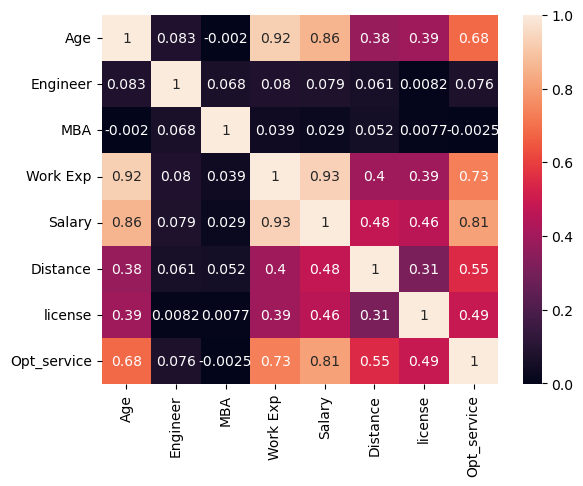

In [4]:
data_corr = sns.heatmap(data.corr(),annot=True)

In [6]:
OHE_col = pd.get_dummies(data['Gender'], drop_first=True)

data_model = pd.concat([data,OHE_col],1).reset_index(drop=True)

data_model.drop(columns = ['Gender'],axis = 1, inplace = True)

data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          418 non-null    int64  
 1   Engineer     418 non-null    int64  
 2   MBA          418 non-null    int64  
 3   Work Exp     418 non-null    int64  
 4   Salary       418 non-null    float64
 5   Distance     418 non-null    float64
 6   license      418 non-null    int64  
 7   Opt_service  418 non-null    int64  
 8   Male         418 non-null    uint8  
dtypes: float64(2), int64(6), uint8(1)
memory usage: 26.7 KB


In [7]:
X = data_model.drop(columns = ['Opt_service'], axis = 1)
Y = data_model['Opt_service']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.30, random_state=1)

In [11]:
Y_test.value_counts()/len(Y_test)

0    0.912698
1    0.087302
Name: Opt_service, dtype: float64

In [12]:
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,Y_train)

BaggingClassifier(random_state=1)

In [18]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_train)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

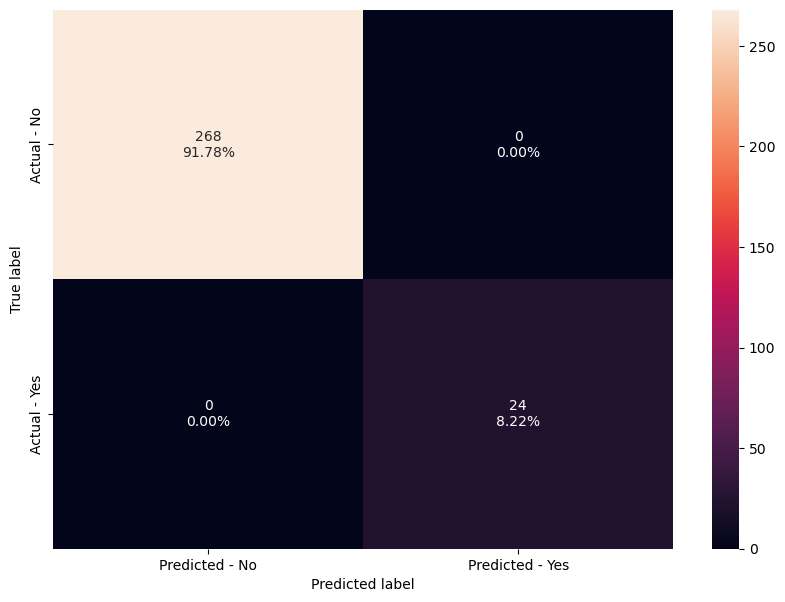

In [19]:
make_confusion_matrix(bagging_estimator,Y_train)

In [25]:
for depth in range(1,6):
    bagging_dt=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth),random_state=1)
    bagging_dt.fit(X_train,Y_train)
    pred_train = bagging_dt.predict(X_train)

    train_f1 = metrics.f1_score(Y_train,pred_train)

    print('The F1 score for max depth', depth,' is ', train_f1)

The F1 score for max depth 1  is  0.8400000000000001
The F1 score for max depth 2  is  0.9787234042553191
The F1 score for max depth 3  is  0.9787234042553191
The F1 score for max depth 4  is  0.9787234042553191
The F1 score for max depth 5  is  1.0


In [30]:
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,Y_train)
    test_acc = model.score(X_test,Y_test)
    
    train_recall = metrics.recall_score(Y_train,pred_train)
    test_recall = metrics.recall_score(Y_test,pred_test)
    
    train_precision = metrics.precision_score(Y_train,pred_train)
    test_precision = metrics.precision_score(Y_test,pred_test)
    
    train_f1 = metrics.f1_score(Y_train,pred_train)
    test_f1 = metrics.f1_score(Y_test,pred_test)

    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,Y_train))
        print("Accuracy on test set : ",model.score(X_test,Y_test))
        print("Recall on training set : ",metrics.recall_score(Y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(Y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(Y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(Y_test,pred_test))
        print("F1 score on training set : ",metrics.f1_score(Y_train,pred_train))
        print("F1 score on test set : ",metrics.f1_score(Y_test,pred_test))
    
    return score_list # returning the list with train and test scores

In [31]:
bagging_lr=BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear',random_state=1),random_state=1)
bagging_lr.fit(X_train,Y_train)

get_metrics_score(bagging_lr)

Accuracy on training set :  0.9931506849315068
Accuracy on test set :  0.9920634920634921
Recall on training set :  0.9166666666666666
Recall on test set :  1.0
Precision on training set :  1.0
Precision on test set :  0.9166666666666666
F1 score on training set :  0.9565217391304348
F1 score on test set :  0.9565217391304348


[0.9931506849315068,
 0.9920634920634921,
 0.9166666666666666,
 1.0,
 1.0,
 0.9166666666666666,
 0.9565217391304348,
 0.9565217391304348]

In [36]:
rf_estimator=RandomForestClassifier(class_weight = 'balanced', random_state=1)
rf_estimator.fit(X_train,Y_train)
get_metrics_score(rf_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.9920634920634921
Recall on training set :  1.0
Recall on test set :  1.0
Precision on training set :  1.0
Precision on test set :  0.9166666666666666
F1 score on training set :  1.0
F1 score on test set :  0.9565217391304348


[1.0,
 0.9920634920634921,
 1.0,
 1.0,
 1.0,
 0.9166666666666666,
 1.0,
 0.9565217391304348]

In [35]:
# Choose the type of classifier. 
RF_estimator_tuned = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    'min_samples_split' : [2,5,7],
    'n_estimators' : [10,30,50,70],
             }

# Type of scoring used to compare parameter combinations
f1_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(RF_estimator_tuned, parameters, scoring=f1_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, Y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_tuned.fit(X_train, Y_train)

print(grid_obj.best_params_)

{'min_samples_split': 2, 'n_estimators': 30}
